# Part 1: Single subject classification (subject 1)
### Import required libraries

In [1]:
# Import Required Libraries
import os
import zipfile
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
from script import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

### Load and extract data

In [3]:
# Load and Extract Data

# Define the path to the zip file and the extraction directory
zip_file_path = '../data/s1.zip'
extraction_dir = '../data/'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# Define the paths to the .mat files
mat_file_path = os.path.join(extraction_dir, 'S1_A1_E1.mat')
mat_file_path_e2 = os.path.join(extraction_dir, 'S1_A1_E2.mat')
mat_file_path_e3 = os.path.join(extraction_dir, 'S1_A1_E3.mat')

# Delete the S1_A1_E2.mat and S1_A1_E3.mat files
if os.path.exists(mat_file_path_e2):
    os.remove(mat_file_path_e2)
if os.path.exists(mat_file_path_e3):
    os.remove(mat_file_path_e3)

# Load the .mat file using scipy.io.loadmat
mat_data = sio.loadmat(mat_file_path)

# Extract the data and labels
data = mat_data['emg']
labels = mat_data['restimulus']

# Print the shape of the data and labels
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (101014, 10)
Labels shape: (101014, 1)


### Visualize raw EMG data

/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_40729/3927917370.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', data.shape[1])


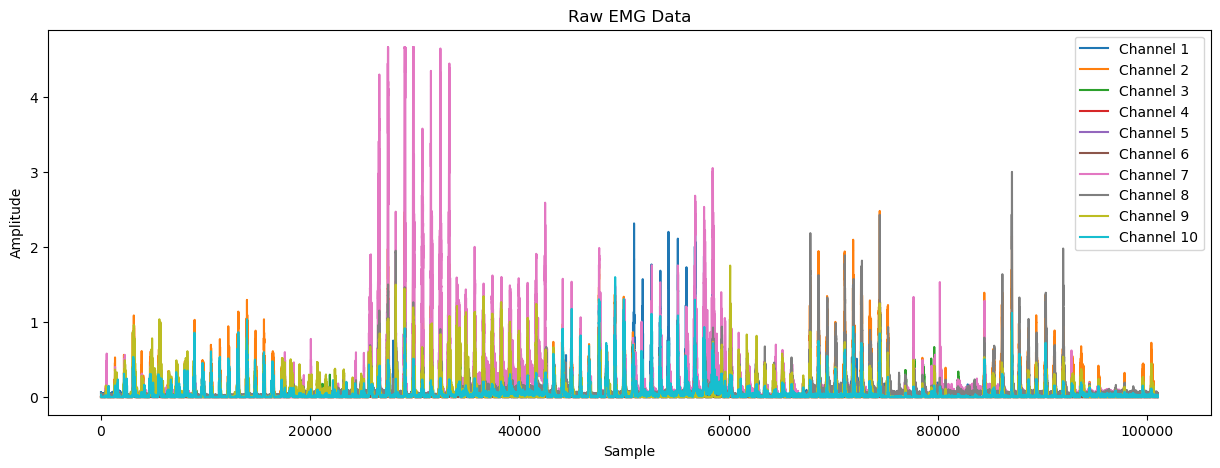

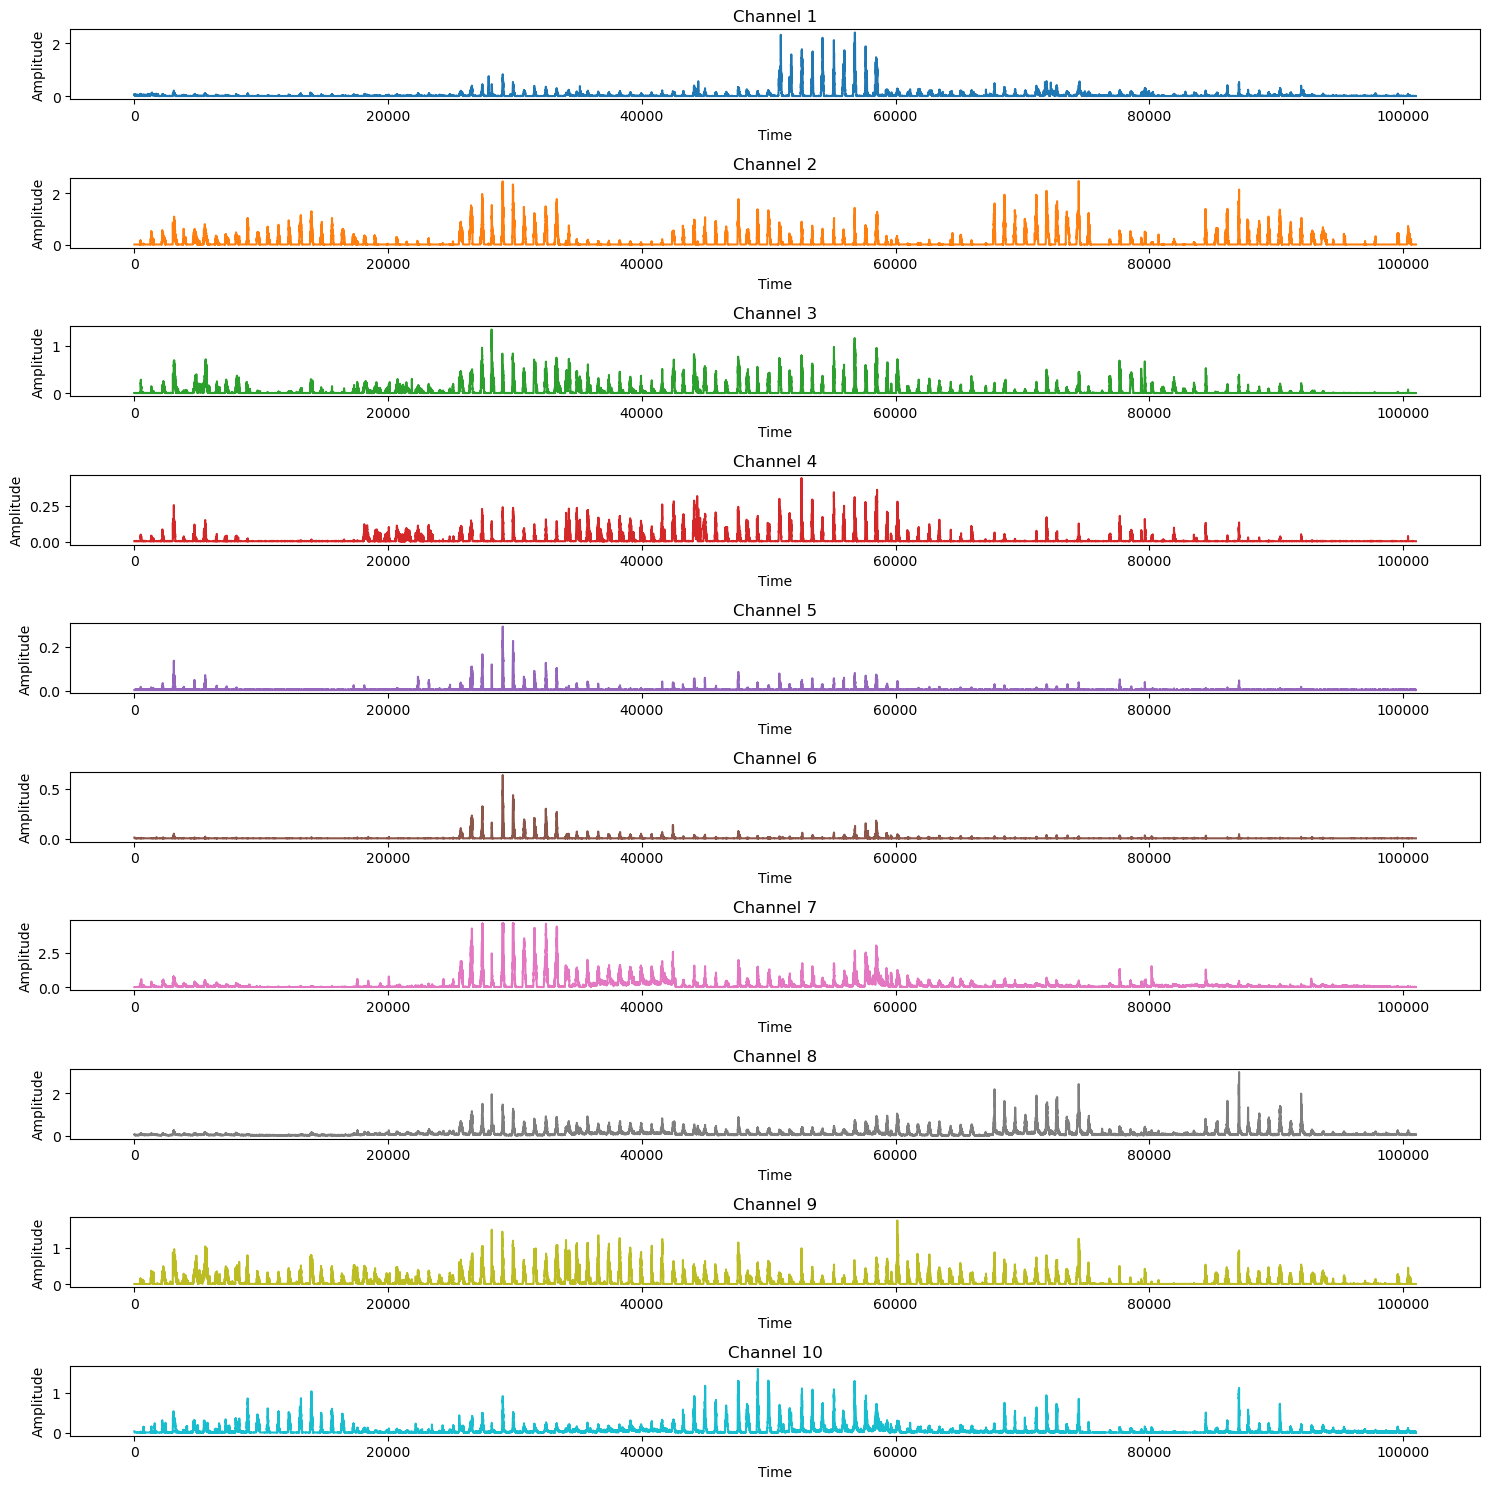

In [4]:
# Visualize Raw EMG Data

# Define a color map
colors = plt.cm.get_cmap('tab10', data.shape[1])
num_channels = data.shape[1]

# Plot all channels in a single plot
plt.figure(figsize=(15, 5))
for i in range(num_channels):
    plt.plot(data[:, i], label=f'Channel {i+1}', color=colors(i))
plt.title('Raw EMG Data')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.show()

# Plot each channel in a separate subplot
plt.figure(figsize=(15, 15))
for i in range(num_channels):
    plt.subplot(num_channels, 1, i + 1)
    plt.plot(data[:, i], color=colors(i))
    plt.title(f'Channel {i + 1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

### Preprocess EMG data

In [5]:
# Preprocess EMG Data

# Apply bandpass filter to the data
fs = 1000  # Sampling frequency (Hz)
lowcut = 20.0  # Low cut frequency (Hz)
highcut = 450.0  # High cut frequency (Hz)
filtered_data = bandpass_filter(data, lowcut, highcut, fs)

# Normalize the data
normalized_data = (filtered_data - np.mean(filtered_data, axis=0)) / np.std(filtered_data, axis=0)

### Visualize preprocessed EMG data

/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_40729/1132282992.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', normalized_data.shape[1])


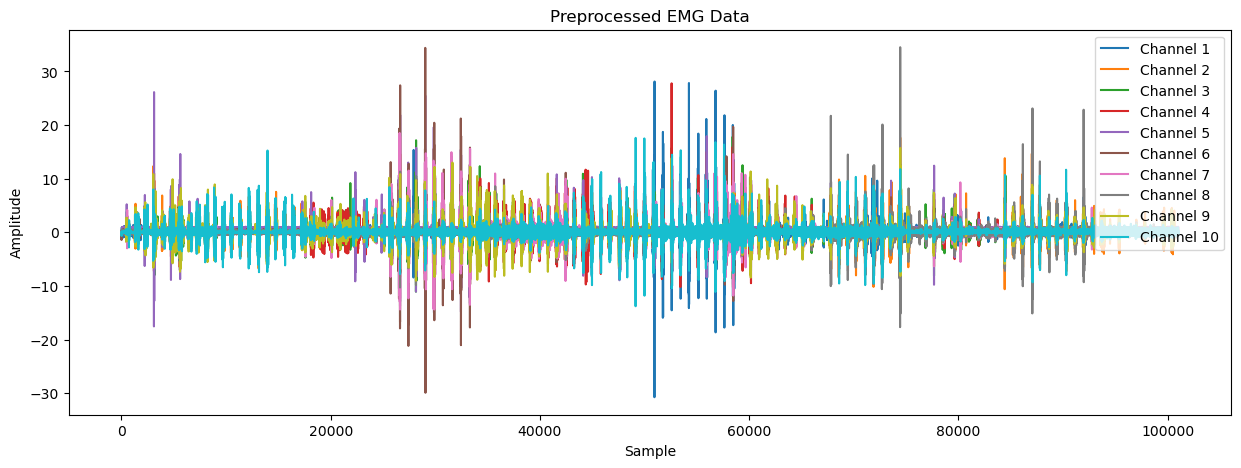

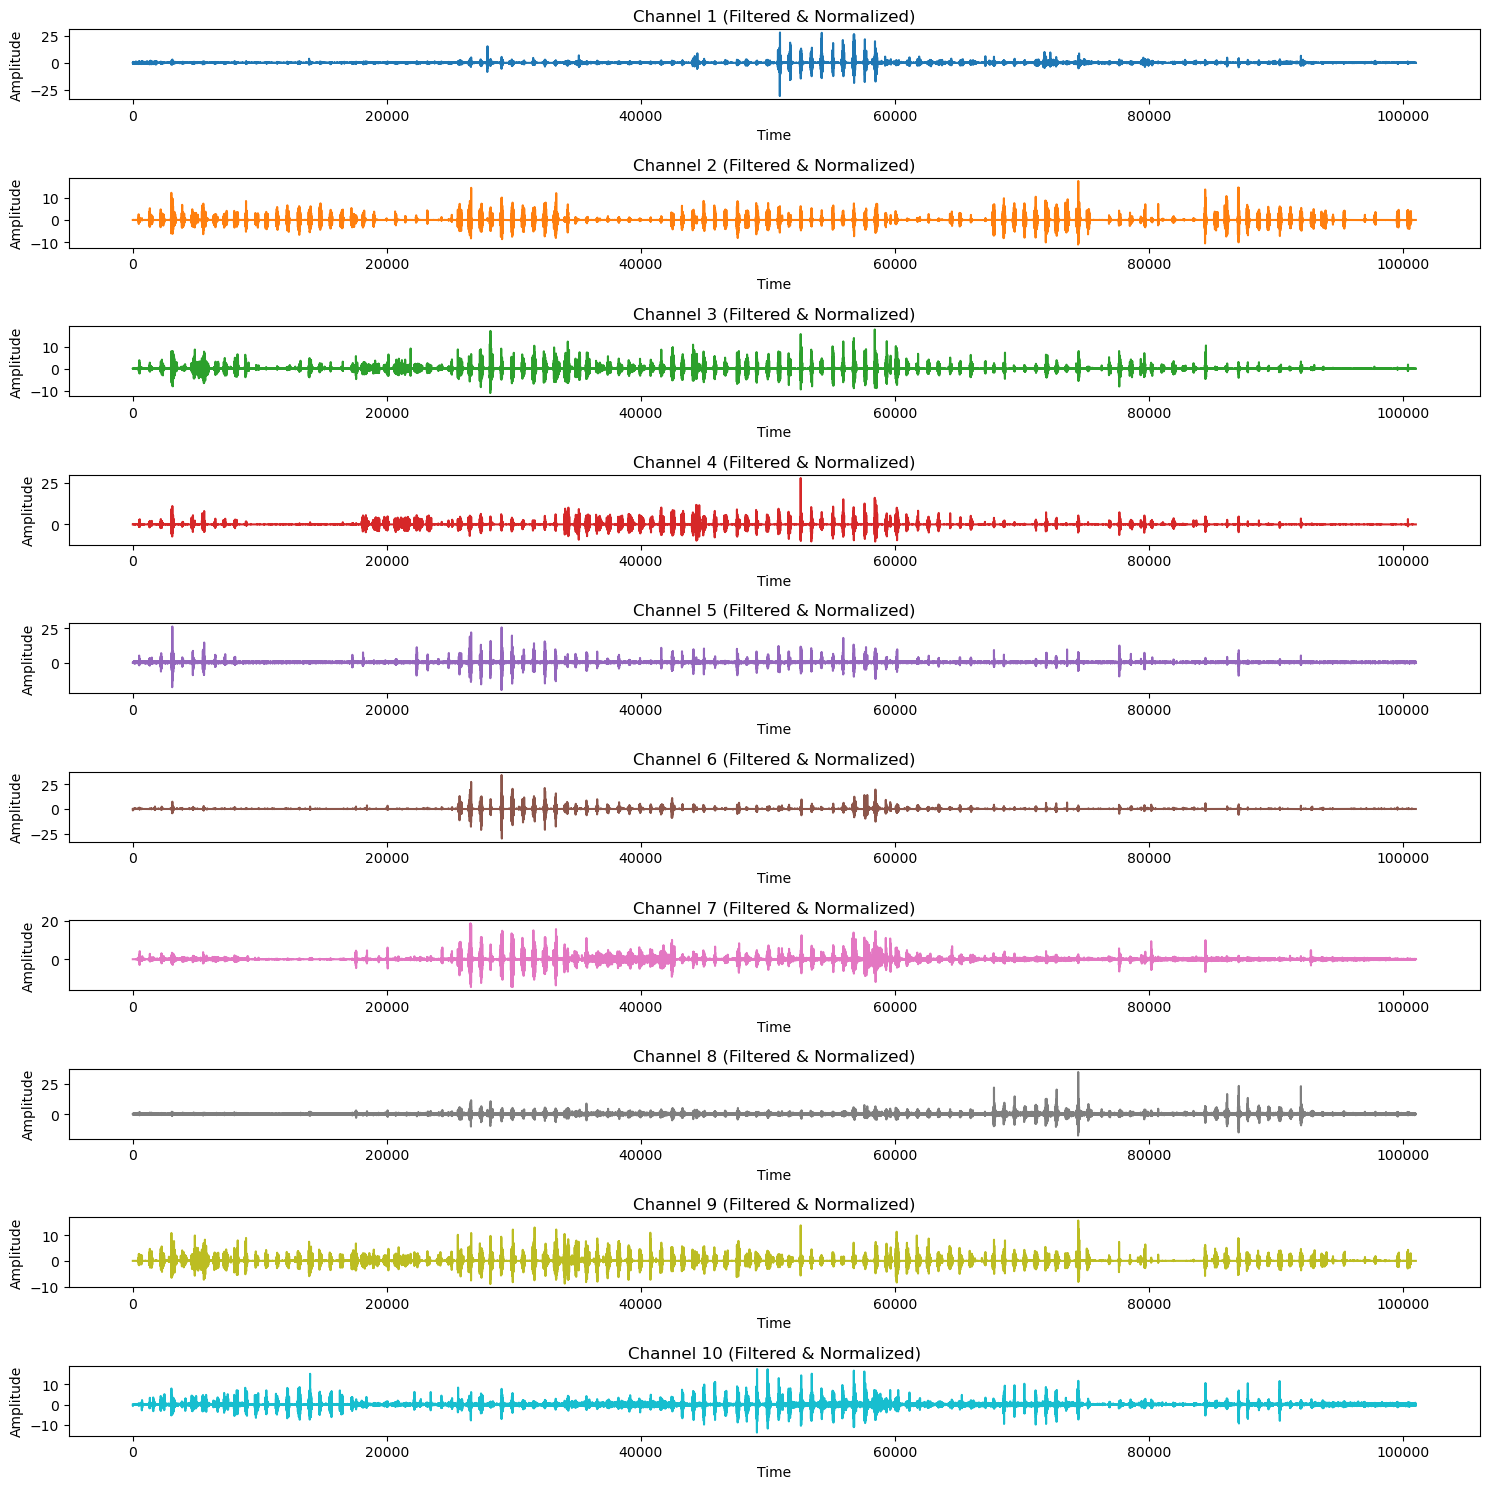

In [6]:
# Visualize Preprocessed EMG Data

# Define a color map
colors = plt.cm.get_cmap('tab10', normalized_data.shape[1])
num_channels = normalized_data.shape[1]

# Plot all channels in a single plot
plt.figure(figsize=(15, 5))
for i in range(num_channels):
    plt.plot(normalized_data[:, i], label=f'Channel {i+1}', color=colors(i))
plt.title('Preprocessed EMG Data')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.show()

# Plot each channel in a separate subplot
plt.figure(figsize=(15, 15))
for i in range(num_channels):
    plt.subplot(num_channels, 1, i + 1)
    plt.plot(normalized_data[:, i], color=colors(i))
    plt.title(f'Channel {i + 1} (Filtered & Normalized)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

**Question:** 

Does the data look reasonable? Did you need to remove any trials?

**Answer:** 

...

### Split the data into training, validation, and testing sets

In [7]:
# Assuming 'data' and 'labels' are already loaded and preprocessed

# Define the split ratios
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# First, split the data into training and temp sets
data_train, data_temp, labels_train, labels_temp = train_test_split(data, labels, test_size=(1 - train_ratio), random_state=42)

# Then, split the temp set into validation and test sets
data_val, data_test, labels_val, labels_test = train_test_split(data_temp, labels_temp, test_size=(test_ratio / (test_ratio + validation_ratio)), random_state=42)

# Print the shapes of the resulting datasets
print("Training data shape:", data_train.shape)
print("Validation data shape:", data_val.shape)
print("Testing data shape:", data_test.shape)
print("Training labels shape:", labels_train.shape)
print("Validation labels shape:", labels_val.shape)
print("Testing labels shape:", labels_test.shape)

Training data shape: (70709, 10)
Validation data shape: (15152, 10)
Testing data shape: (15153, 10)
Training labels shape: (70709, 1)
Validation labels shape: (15152, 1)
Testing labels shape: (15153, 1)


**Question:** 

Why do we need the different datasets?

**Answer:** 

Different datasets are used to ensure a machine learning model generalizes well to new data. The training set is used to learn and adjust model parameters, the validation set is used to tune hyperparameters and select the best model configuration, and the testing set provides an unbiased evaluation of the final model's performance on unseen data. This approach helps prevent overfitting and ensures the model performs well in real-world applications.

### Extract features from the trials

In [8]:
# Print the shape of the data
print("Data shape:", data.shape)

# Define the number of samples per trial
samples_per_trial = 1000
data_reshaped = reshape_data(data, samples_per_trial)

# Print the shape of the reshaped data
print("Reshaped data shape:", data_reshaped.shape)

# Extract features from the reshaped data
features = extract_features_from_data(data_reshaped)

# Print the shape of the extracted features
print("Extracted features shape:", features.shape)

Data shape: (101014, 10)
Reshaped data shape: (101, 1000, 10)
Extracted features shape: (101, 60)


### Look at the typical values of the features across the different trials

            MAV_1      MAVS_1       RMS_1   ZC_1        WL_1       SSC_1  \
count  101.000000  101.000000  101.000000  101.0  101.000000  101.000000   
mean     0.039698    0.003632    0.079710    0.0    3.628458  309.861386   
std      0.048070    0.003625    0.107298    0.0    3.621032   74.795325   
min      0.003661    0.000453    0.004743    0.0    0.452800  157.000000   
25%      0.012509    0.001660    0.021600    0.0    1.658300  247.000000   
50%      0.023217    0.002276    0.043254    0.0    2.274000  310.000000   
75%      0.038575    0.004149    0.075820    0.0    4.145200  372.000000   
max      0.261187    0.018723    0.511330    0.0   18.704700  471.000000   

            MAV_2      MAVS_2       RMS_2        ZC_2  ...       RMS_9  \
count  101.000000  101.000000  101.000000  101.000000  ...  101.000000   
mean     0.086169    0.006623    0.187936    0.079208  ...    0.144565   
std      0.080823    0.004901    0.161179    0.391999  ...    0.095109   
min      0.002400  

/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_40729/708117549.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_channels)
/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_40729/708117549.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(indices, summary_stats.loc['mean'][indices], yerr=summary_stats.loc['std'][indices], fmt='o', ecolor=colors(i), capsize=5, label=f'Channel {i+1}')


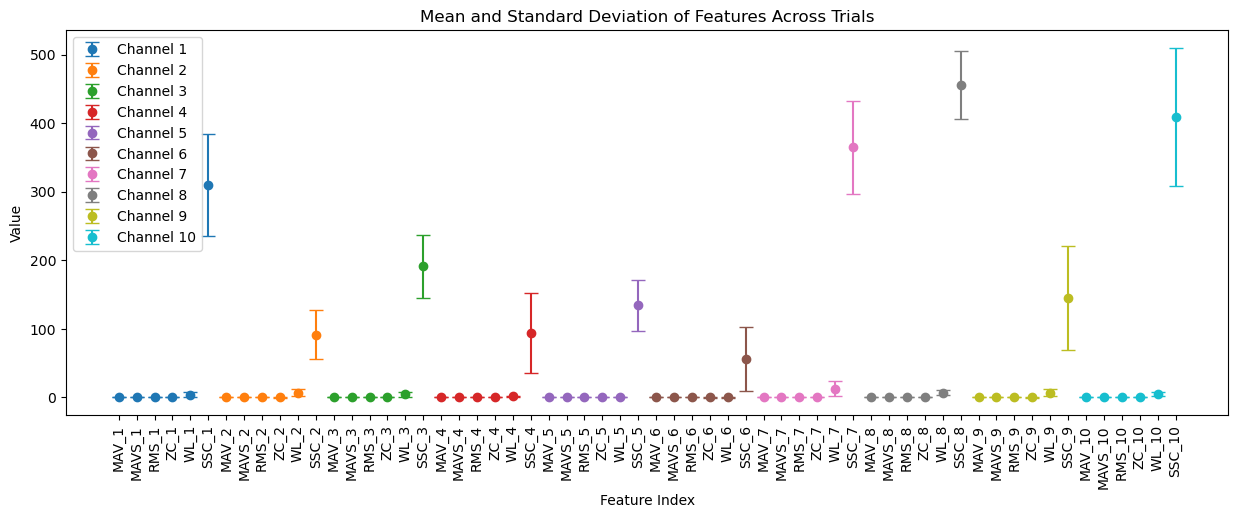

/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_40729/708117549.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.errorbar(j, summary_stats.loc['mean'][index], yerr=summary_stats.loc['std'][index], fmt='o', ecolor=colors(j), capsize=5, label=f'Channel {j+1}' if i == 0 else "")
/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_40729/708117549.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.errorbar(j, summary_stats.loc['mean'][index], yerr=summary_stats.loc['std'][index], fmt='o', ecolor=colors(j), capsize=5, label=f'Channel {j+1}' if i == 0 else "")
/var/folders/q_/xhgs30s966s2xsy_tl

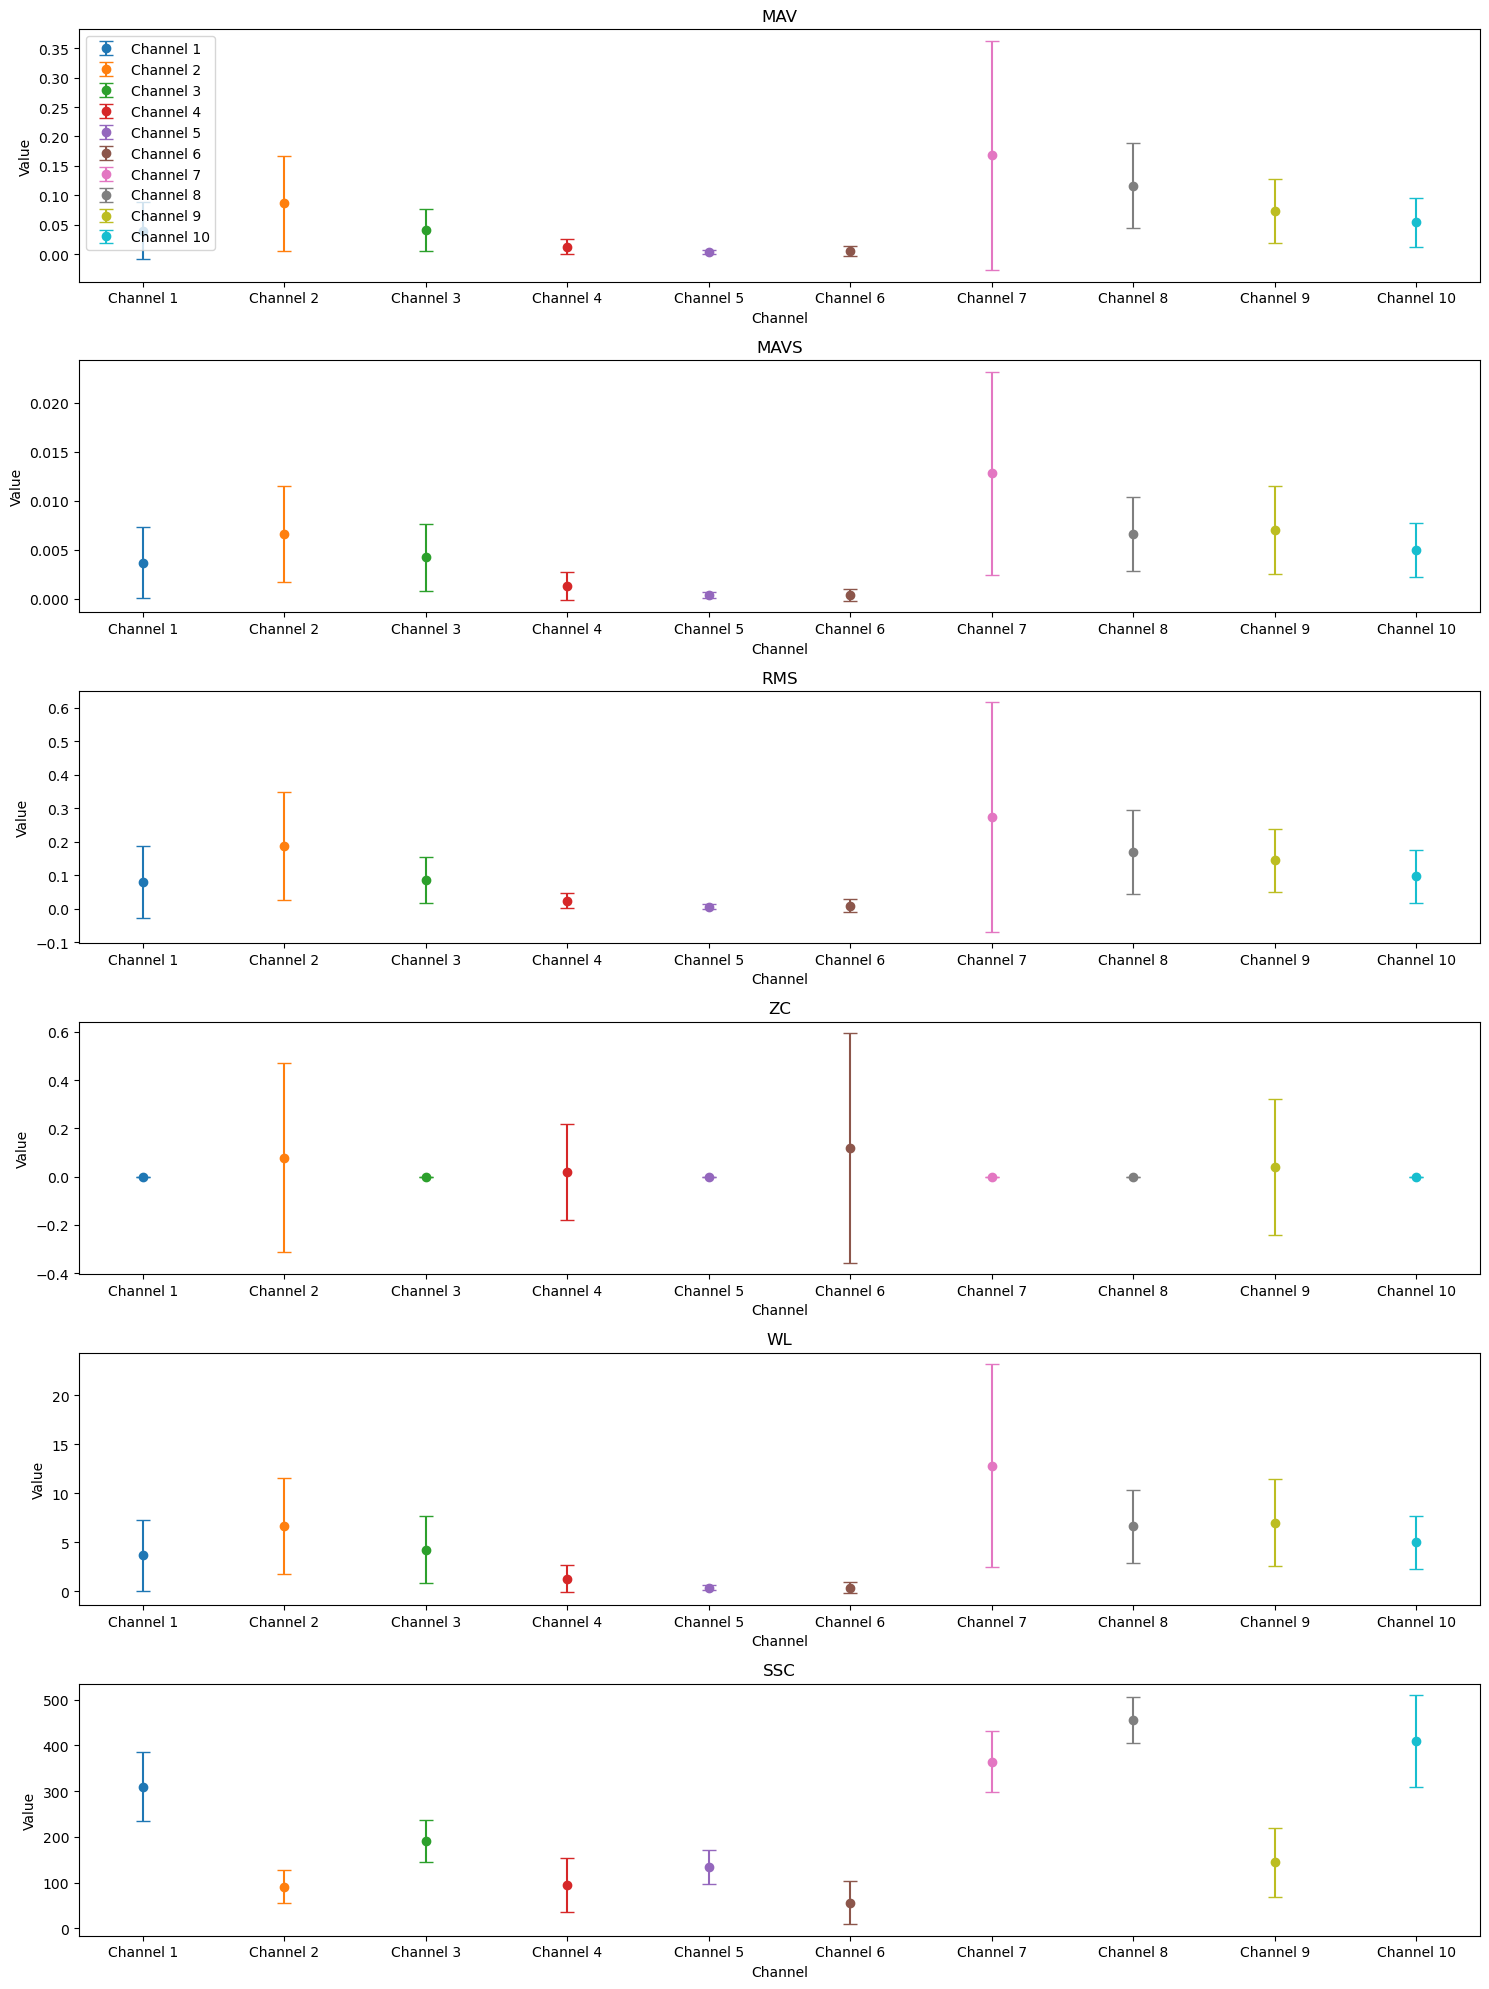

In [9]:
# Assuming 'features' is the matrix of extracted features with shape (num_trials, num_features)
num_trials, num_features = features.shape
num_channels = num_features // 6

# Generate feature names
feature_names = []
for i in range(num_channels):
    feature_names.extend([
        f'MAV_{i+1}', f'MAVS_{i+1}', f'RMS_{i+1}', f'ZC_{i+1}', f'WL_{i+1}', f'SSC_{i+1}'
    ])

# Convert the features matrix to a DataFrame for easier analysis
features_df = pd.DataFrame(features, columns=feature_names)

# Compute and print summary statistics
summary_stats = features_df.describe()
print(summary_stats)

# Define a color map
colors = plt.cm.get_cmap('tab10', num_channels)

# Plot the mean and standard deviation of each feature
plt.figure(figsize=(15, 5))
for i in range(num_channels):
    indices = range(i * 6, (i + 1) * 6)
    plt.errorbar(indices, summary_stats.loc['mean'][indices], yerr=summary_stats.loc['std'][indices], fmt='o', ecolor=colors(i), capsize=5, label=f'Channel {i+1}')
plt.title('Mean and Standard Deviation of Features Across Trials')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.xticks(ticks=range(num_features), labels=feature_names, rotation=90)
plt.legend(loc='upper left')
plt.show()

# Plot the mean and standard deviation of each feature
fig, axes = plt.subplots(6, 1, figsize=(15, 20))
feature_types = ['MAV', 'MAVS', 'RMS', 'ZC', 'WL', 'SSC']

for i, feature_type in enumerate(feature_types):
    ax = axes[i]
    for j in range(num_channels):
        index = i + j * 6
        ax.errorbar(j, summary_stats.loc['mean'][index], yerr=summary_stats.loc['std'][index], fmt='o', ecolor=colors(j), capsize=5, label=f'Channel {j+1}' if i == 0 else "")
    ax.set_title(f'{feature_type}')
    ax.set_xlabel('Channel')
    ax.set_ylabel('Value')
    ax.set_xticks(range(num_channels))
    ax.set_xticklabels([f'Channel {j+1}' for j in range(num_channels)])
    if i == 0:
        ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

**Question:** 

What do you see? Are the values similar between repetitions and between channels? Explain the possible reasons for similarity/discrepancies.

**Answer:** 

In most channels, we know that the values are similar between repetitions because the mean values of the features for each channel have relatively small standard deviations, as shown by the error bars in the plots, indicating a stable and repeatable EMG signals for the same movements. 

However, there are noticeable differences in feature values between channels. These discrepancies can be attributed to factors such as variations in electrode placement, differences in muscle activation, and varying levels of signal noise, highlighting the impact of physiological and technical factors on EMG signal characteristics.

### Perform classification on the data (Random Forest)